In [1]:
#VALIDATION_SET: built in to model.fit
#ACTIVATION: sigmoid
#HYPERPARAMETERS: hardcoded
#LOSS: binary_crossentropy
#OPTIMIZER: adam
#VISUALIZATION: loss vs LSTM epoch, f1 score

In [2]:
import pandas as pd
import numpy as np
from sklearn.cross_validation import train_test_split
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers.core import Dense
from keras.layers.core import Dropout
from keras.layers.core import Activation
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM
import sklearn
import pandas as pd
import numpy as np
import re
from sklearn import metrics
from keras.preprocessing import sequence

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


In [3]:
females_names_path = '/Users/beh502/Downloads/names/female.txt'
male_names_path = '/Users/beh502/Downloads/names/male.txt'
internet_words_path = '/Users/beh502/Downloads/unigram_freq.csv'

In [4]:
with open(females_names_path) as f:
    female_lines = f.read().splitlines()
with open(male_names_path) as f:
    male_lines = f.read().splitlines()

In [5]:
names_list = list(set(male_lines + female_lines))
names_df = pd.DataFrame(np.array(names_list), columns = ['word'])
names_df['target'] = 1

In [6]:
# create DF out of internet words, drop count column add target column
#want 50/50 distribution in data, no bias
internet_df = pd.read_csv(internet_words_path, nrows=names_df.shape[0])
internet_df['target'] = 0
internet_df = internet_df.drop(['count'], axis=1)
# use outer so names in internet_df that appear in names_df get target 1
merged_df = pd.merge(names_df, internet_df, how='outer', on=['word', 'target'])

In [7]:
merged_df = merged_df.dropna()
merged_df['word'] = merged_df['word'].str.lower()
merged_df['word'] = merged_df['word'].str.strip()
merged_df['word_length'] = merged_df['word'].apply(lambda x: len(x))
X = merged_df['word']
y = merged_df['target']

In [8]:
valid_chars = {x:idx+1 for idx, x in enumerate(set(''.join(X)))}

In [9]:
max_word_len = np.max([len(x) for x in X])
max_features = len(valid_chars) + 1
x_data_sequences = [[valid_chars[char] for char in word] for word in X]
x_data_sequences = sequence.pad_sequences(x_data_sequences, maxlen=max_word_len)

In [10]:
embedding_layer = Embedding(max_features, output_dim=64, input_length=max_word_len)
lstm_layer = LSTM(max_features)
dropout_layer = Dropout(0.5)
dense_layer = Dense(1)
sigmoid_layer = Activation('sigmoid')

model = Sequential([embedding_layer, lstm_layer, dropout_layer, dense_layer, sigmoid_layer])
model.compile(loss='binary_crossentropy', optimizer='SGD')

In [11]:
epochs = 15
batch_size = 32
X_train, X_test, y_train, y_test = train_test_split(x_data_sequences, y, test_size=0.2, random_state=0)
history = model.fit(X_train, y_train, epochs = epochs, validation_split=0.33, batch_size = batch_size)
predicted_y_test = model.predict(X_test)

Train on 8123 samples, validate on 4002 samples
Epoch 1/15
8123/8123 [==============================] - 5s 647us/step - loss: 0.6918 - val_loss: 0.6905
Epoch 2/15
8123/8123 [==============================] - 5s 570us/step - loss: 0.6896 - val_loss: 0.6881
Epoch 3/15
8123/8123 [==============================] - 5s 577us/step - loss: 0.6873 - val_loss: 0.6860
Epoch 4/15
8123/8123 [==============================] - 5s 585us/step - loss: 0.6847 - val_loss: 0.6830
Epoch 5/15
8123/8123 [==============================] - 5s 572us/step - loss: 0.6820 - val_loss: 0.6799
Epoch 6/15
8123/8123 [==============================] - 5s 572us/step - loss: 0.6791 - val_loss: 0.6766
Epoch 7/15
8123/8123 [==============================] - 5s 583us/step - loss: 0.6760 - val_loss: 0.6730
Epoch 8/15
8123/8123 [==============================] - 5s 579us/step - loss: 0.6720 - val_loss: 0.6686
Epoch 9/15
8123/8123 [==============================] - 5s 573us/step - loss: 0.6671 - val_loss: 0.6637
Epoch 10/15
8123

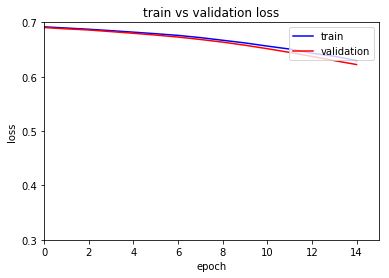

In [12]:
%matplotlib inline
pyplot.plot(history.history['loss'], color='blue')
pyplot.plot(history.history['val_loss'], color='red')
pyplot.title('train vs validation loss')
pyplot.ylabel('loss')
pyplot.xlabel('epoch')
pyplot.xlim(0, 15)
pyplot.ylim(0.3, 0.7)
pyplot.yticks([0.3, 0.4, 0.5, 0.6, 0.7])
pyplot.legend(['train', 'validation'], loc='upper right')
pyplot.show()

In [13]:
#Create a function to map sequences back to strings for predictions
#for lookup it's easier to use an inverted version of valid_chars

inverted_valid_chars = {v: k for k, v in valid_chars.items()}

def sequence_to_string(sequence):
    constructed = ''
    inverted_keys = list(inverted_valid_chars.keys())
    for num in sequence:
        if(num != 0):
            constructed += inverted_valid_chars[num]
    return constructed

In [15]:
def get_ratio(word):
    vowel_count = 0
    char_count = len(word)
    vowels = ['a','i','e','o','u'] #sorry y, it's a full time job
    for c in word:
        if(c in vowels):
            vowel_count+= 1
    return (float(vowel_count)/char_count)
    

In [22]:
predicted_y_test = predicted_y_test.flatten()
words = [sequence_to_string(x) for x in X_test]
word_lengths = [len(sequence_to_string(x)) for x in X_test]
mapped_predictions = [1 if y_pred >= 0.5 else 0 for y_pred in predicted_y_test]
vowel_ratio = [get_ratio(x) for x in words]

eval_df = pd.DataFrame({'word': words, 'word_length': word_lengths, 'y_true': y_test,
                        'y_pred': predicted_y_test, 'rounded_y_pred': mapped_predictions,
                        'vowel_ratio': vowel_ratio
                       })
#reorder columns for pretty print
eval_df = eval_df[['word', 'word_length', 'vowel_ratio', 'y_pred', 'rounded_y_pred', 'y_true']]
print(eval_df.head(5))

          word  word_length  vowel_ratio    y_pred  rounded_y_pred  y_true
6617     winni            5     0.400000  0.558790               1       1
3515    maurie            6     0.666667  0.567530               1       1
8241   schools            7     0.285714  0.307907               0       0
167      reggi            5     0.400000  0.434538               0       1
1391  thedrick            8     0.250000  0.457030               0       1


In [23]:
zeros = eval_df.loc[eval_df['y_true'] == 0]
print(zeros.shape[0])
ones = eval_df.loc[eval_df['y_true'] == 1]
print(ones.shape[0])

1550
1482


In [24]:
f1_score = metrics.f1_score(eval_df['y_true'].values, eval_df['rounded_y_pred'].values)
accuracy_score = metrics.accuracy_score(eval_df['y_true'].values, eval_df['rounded_y_pred'].values)
print("accuracy score: ", str(accuracy_score))
print("f1 score: ", str(f1_score))
print("log loss score: ", str(history.history['loss'][-1]))

accuracy score:  0.685686015831
f1 score:  0.676180767924
log loss score:  0.629870152115


## Visualization

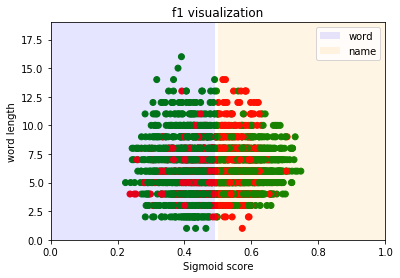

In [25]:
# plot word length vs predictions
pyplot.figure()
pyplot.xlim(0, 1)
pyplot.ylim(0, max_word_len + 1)

#set background color
pyplot.axvspan(0, 0.49, facecolor='blue',alpha=0.1)
pyplot.axvspan(0.5, 1, facecolor='orange', alpha=0.1)

#determine point colors
colors = []
listed_y_test = y_test.values
for i in range(0, len(mapped_predictions)):
    if(mapped_predictions[i] == listed_y_test[i]):
        colors.append('green')
    else:
        colors.append('red')

#plot points
x_points = predicted_y_test
y_points = word_lengths
pyplot.title('f1 visualization')
pyplot.ylabel('word length')
pyplot.xlabel('Sigmoid score')
pyplot.legend(['word', 'name'], loc='upper right')
pyplot.scatter(x_points, y_points, c=colors)
pyplot.show()

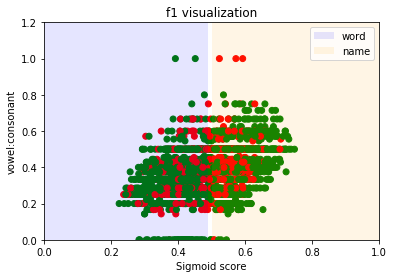

In [26]:
# plot word length vs predictions
pyplot.figure()
pyplot.xlim(0, 1)
pyplot.ylim(0, 1.2)

#set background color
pyplot.axvspan(0, 0.49, facecolor='blue',alpha=0.1)
pyplot.axvspan(0.5, 1, facecolor='orange', alpha=0.1)

#determine point colors
colors = []
listed_y_test = y_test.values
for i in range(0, len(mapped_predictions)):
    if(mapped_predictions[i] == listed_y_test[i]):
        colors.append('green')
    else:
        colors.append('red')

#plot points
x_points = predicted_y_test
y_points = vowel_ratio
pyplot.title('f1 visualization')
pyplot.ylabel('vowel:consonant')
pyplot.xlabel('Sigmoid score')
pyplot.legend(['word', 'name'], loc='upper right')
pyplot.scatter(x_points, y_points, c=colors)
pyplot.show()